In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as Fun
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook

In [2]:
#REPRODUCIBILITY

# Setting the seed
random.seed(42)
g = torch.Generator().manual_seed(2147483647)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [41]:
# Apply random transformations

def random_transform(image):
  if random.random() < 0.8:  # 50% prob of applying a transformation
    if random.random() < 0.5:  # 50% prob of rotation
      angle = random.choice([0, 90, 180, 270])
      image = Fun.rotate(image, angle)
    else:  # otherwise translation
      translate = (random.uniform(0, 0.1), random.uniform(0, 0.1))
      image = Fun.affine(image, angle=0, translate=translate, scale=1, shear=0)
  return image

# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([
  T.Lambda(random_transform), #apply random transformation
  T.ToTensor(),
  T.Normalize((0.5,), (0.5,))])

# download fashionMNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/training', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download fashionMNIST test set
test_set = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/testing', train=False, download=True, transform=MNIST_preprocess)

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

In [42]:
# print the dimension of images to verify all loaders have the same dimensions
def print_dim(loader, text):
  print('---------'+text+'---------')
  print(len(loader.dataset))
  for image, label in loader:
    print(image.shape)
    print(label.shape)
    break

print_dim(train_loader,'training loader')
print_dim(val_loader,'validation loader')
print_dim(test_loader,'test loader')

---------training loader---------
50000
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------validation loader---------
10000
torch.Size([32, 1, 28, 28])
torch.Size([32])
---------test loader---------
10000
torch.Size([32, 1, 28, 28])
torch.Size([32])


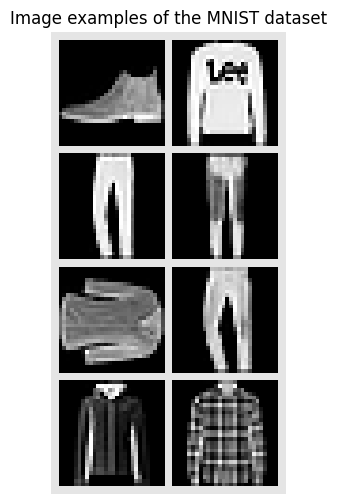

In [92]:
# Visualize some examples
NUM_IMAGES = 8
MNIST_examples = torch.stack([test_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_examples, nrow=2, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(6, 6))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [44]:
image_size = 28
embed_dim=255
hidden_dim=embed_dim*3
num_heads=3
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

In [45]:
#PATCH EMBEDDING

def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape # [B, C, H, W], MNIST [B, 1, 28, 28]
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size) # [B, C, H', p_H, W', p_W], MNIST [B, 1, 4, 7, 4, 7]
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W], MNIST [B, 4, 4, 1, 7, 7]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W], MNIST [B, 16, 1, 7, 7]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W], MNIST [B, 16, 49]
    return x

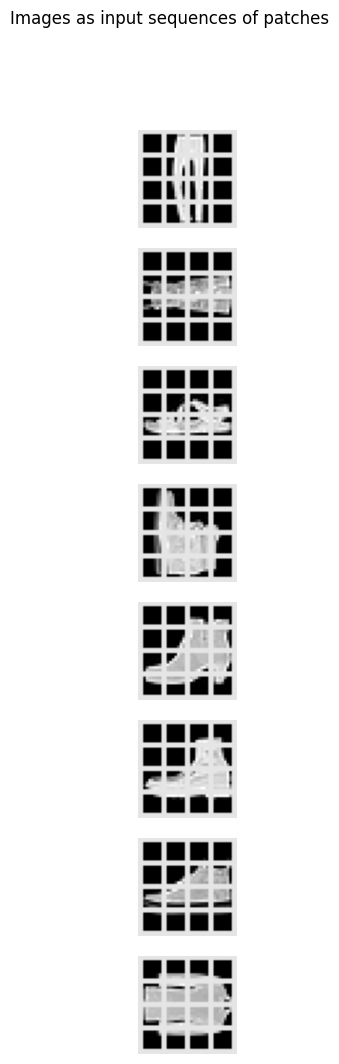

In [46]:
# VISUALIZE THE IMAGE PATCHES
img_patches = img_to_patch(MNIST_examples, patch_size=patch_size, flatten_channels=False)

fig, ax = plt.subplots(MNIST_examples.shape[0], 1, figsize=(14, 12))
fig.suptitle("Images as input sequences of patches")
for i in range(MNIST_examples.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=int(image_size/patch_size), normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()

In [47]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [48]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB or 1 for grayscale)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size**2), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        x = img_to_patch(x, self.patch_size)        # x.shape ---> batch, num_patches, (patch_size**2)
        B, T, _ = x.shape
        x = self.input_layer(x)                     # x.shape ---> batch, num_patches, embed_dim

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls_token, x], dim=1)        # x.shape ---> batch, num_patches+1, embed_dim
        x = x + self.pos_embedding[:, : T + 1]      # x.shape ---> batch, num_patches+1, embed_dim

        # Apply Transformer
        x = self.dropout(x)
        x = x.transpose(0, 1)                       # x.shape ---> num_patches+1, batch, embed_dim
        x = self.transformer(x)                     # x.shape ---> num_patches+1, batch, embed_dim

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        return out

In [49]:
model = VisionTransformer(embed_dim=embed_dim,
                          hidden_dim=hidden_dim,
                          num_heads=num_heads,
                          num_layers=num_layers,
                          patch_size=patch_size,
                          num_channels=num_channels,
                          num_patches=num_patches,
                          num_classes=num_classes,
                          dropout=dropout)

# Transfer to GPU
model.to(device)
model_restore = None #'/content/model_20230712_211204_0'
if model_restore is not None and os.path.exists(model_restore):
  model.load_state_dict(torch.load(model_restore))
  model.restored = True

In [12]:
model

VisionTransformer(
  (input_layer): Linear(in_features=49, out_features=255, bias=True)
  (transformer): Sequential(
    (0): AttentionBlock(
      (layer_norm_1): LayerNorm((255,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=255, out_features=255, bias=True)
      )
      (layer_norm_2): LayerNorm((255,), eps=1e-05, elementwise_affine=True)
      (linear): Sequential(
        (0): Linear(in_features=255, out_features=765, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=765, out_features=255, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): AttentionBlock(
      (layer_norm_1): LayerNorm((255,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=255, out_features=255, bias=True)
      )
      (layer_norm_2): Layer

In [50]:
# setup the loss function
loss_fn = torch.nn.CrossEntropyLoss()
# setup the optimizer with the learning rate
model_optimizer = optim.Adam(model.parameters(), lr=3e-4)

# set an empty list to plot the loss later
lossi = []
# set an initial high value for the validation loss
best_vloss = 1_000_000
# set the timestamp to save the training model
timestamp = datetime.now().strftime('%Y%m%d_%H:%M:%S')
# Training loop
for epoch in range(1):
  for imgs, labels in tqdm_notebook(train_loader, desc='epoch '+str(epoch)):
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Transfer to GPU
    imgs, labels = imgs.to(device), labels.to(device)
    # zero the parameter gradients
    model_optimizer.zero_grad()
    # Make predictions for this batch
    preds = model(imgs)
    # Compute the loss and its gradients
    loss = loss_fn(preds, labels)
    # append this loss to the list for later plotting
    lossi.append(loss.item())
    # backpropagate the loss
    loss.backward()
    # adjust parameters based on the calculated gradients
    model_optimizer.step()

  # step the scheduler for the learning rate decay
  running_vloss = 0.0
  # Set the model to evaluation mode, disabling dropout and using population
  # statistics for batch normalization.
  model.eval()

  # Disable gradient computation and reduce memory consumption.
  with torch.no_grad():
      for i, vdata in enumerate(val_loader):
          vinputs, vlabels = vdata
          vinputs, vlabels = vinputs.to(device), vlabels.to(device)
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vlabels)
          running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('LOSS train {:.4f} valid {:.4f}'.format(loss.item(), avg_vloss.item()))

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      model_path = '/model_VisionTransformer_MNIST_{}.pt'.format(epoch+1)
      torch.save(model.state_dict(), model_path)

epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

LOSS train 0.6795 valid 0.6251


RuntimeError: File /model_VisionTransformer_MNIST_1.pt cannot be opened.

Text(0.5, 1.0, 'Training loss')

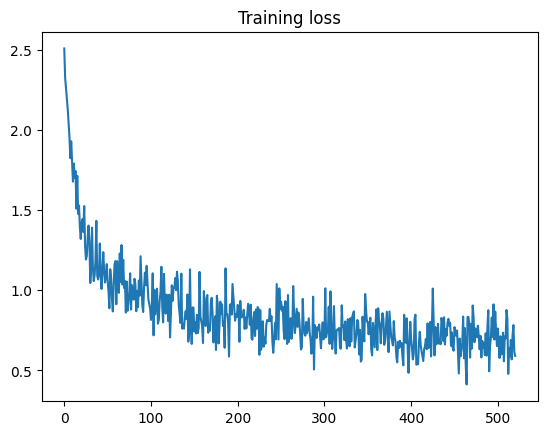

In [51]:
# plot the training loss by averaging every 3 steps
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(torch.tensor(lossi).view(-1, 3).mean(1))
plt.title('Training loss')

In [52]:
model.eval() # Set the model to evaluation mode (dropout disabled)

# evaluate network
acc_total = 0
with torch.no_grad():
  for imgs, labels in tqdm_notebook(test_loader):

    imgs, labels = imgs.to(device), labels.to(device)
    preds = model(imgs)
    pred_cls = preds.data.max(1)[1]
    acc_total += pred_cls.eq(labels.data).cpu().sum()

acc = acc_total.item()/len(test_loader.dataset)
print('Accuracy on test set = '+str(acc))


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on test set = 0.7543


Image tensor shape:  torch.Size([28, 28])
Input tensor to Transformer:  torch.Size([1, 17, 255])
transformer_input_expanded shape:  torch.Size([17, 765])
qkv shape:  torch.Size([3, 3, 17, 85])
q shape:  torch.Size([3, 17, 85])
k shape:  torch.Size([3, 17, 85])
attention matrices shape:  torch.Size([3, 17, 17])
attention_matrices_mean shape:  torch.Size([3, 17])


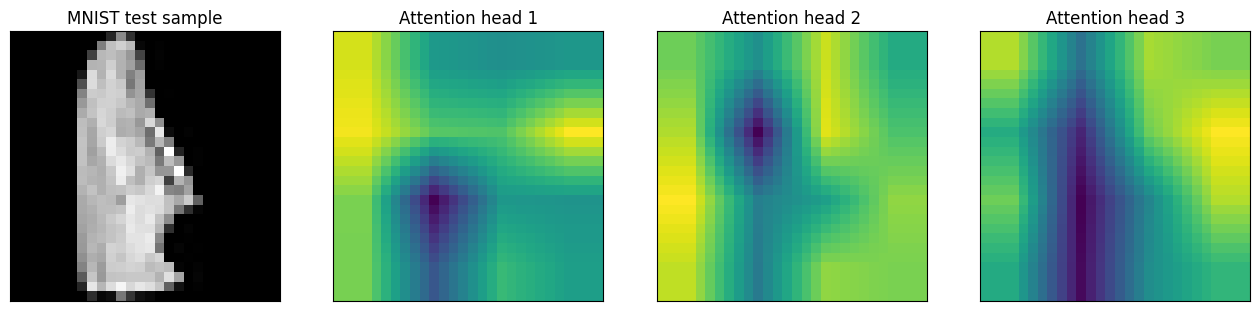

In [117]:
# Estrazione dell'indice del campione di test e preparazione dell'immagine
test_sample_index = (test_set.targets == 7).nonzero(as_tuple=True)[0][12].item()
# Estrazione di un campione di test
img_tensor = test_set[test_sample_index][0].squeeze().to(device)
print ("Image tensor shape: ", img_tensor.shape)
# Conversione dell'immagine in patch
patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
# Passaggio delle patch attraverso lo strato di input per ottenere un tensore di dimensione embed_dim
patches = model.input_layer(patches.float())
# Aggiunta del token di classe e embedding posizionale
transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
print("Input tensor to Transformer: ", transformer_input.shape)

# Passaggio dell'immagine attraverso il primo blocco di attenzione
transformer_input_expanded = model.transformer[0].linear[0](transformer_input).squeeze(0)
print("transformer_input_expanded shape: ", transformer_input_expanded.shape)

# Reshape del risultato della prima attenzione# Reshape del risultato della prima attenzione
qkv = transformer_input_expanded.reshape(num_patches + 1, 3, -1, num_heads).permute(1, 3, 0, 2)
# Dim: (3, num_heads, num_patches + 1, embedding_size // num_heads)
print("qkv shape: ", qkv.shape)

# Estrazione delle matrici di query e key per tutte le attention heads
q = qkv[0]  # Query matrix (num_heads, num_patches + 1, embedding_size // num_heads)
k = qkv[1]  # Key matrix (num_heads, num_patches + 1, embedding_size // num_heads)
print("q shape: ", q.shape)
print("k shape: ", k.shape)

# Moltiplicazione di q e k^T per ottenere le matrici di attenzione per ciascuna head
kT = k.transpose(-2, -1)  # Trasposizione per fare la moltiplicazione corretta
attention_matrices = torch.matmul(q, kT)  # Dim: (num_heads, num_patches + 1, num_patches + 1)
print("attention matrices shape: ", attention_matrices.shape)

# Normalizzazione delle matrici di attenzione per tutte le heads
attention_matrices_mean = torch.mean(attention_matrices, dim=-1)
print("attention_matrices_mean shape: ", attention_matrices_mean.shape)

# Aggiunta delle connessioni residue e normalizzazione
residual_att = torch.eye(attention_matrices.size(-1)).to(device)
aug_att_mats = attention_matrices + residual_att
aug_att_mats = aug_att_mats / aug_att_mats.sum(dim=-1).unsqueeze(-1)

# Visualizzazione delle heatmap per ciascuna head
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
img = np.asarray(img_tensor.cpu())
axes[0].imshow(img, cmap='gray')
axes[0].set_title('MNIST test sample')
axes[0].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)

# Visualizzazione delle heatmap per ogni head
for i in range(3):  # Le prime 3 heads
    attn_heatmap = aug_att_mats[i, 0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
    attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
    axes[i + 1].imshow(attn_heatmap_resized.detach().cpu().numpy())
    axes[i + 1].set_title(f'Attention head {i + 1}')
    axes[i + 1].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)

plt.show()
